In [36]:
import pandas as pd
import numpy as np
import os
from shutil import copytree, rmtree
import cv2
import matplotlib.pyplot as plt
import warnings

In [37]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing import image, image_dataset_from_directory
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow import keras
from random import randint

In [38]:
import os
import shutil
from shutil import copytree, rmtree

default_dir = r"C:\Users\KIIT\Desktop\split_dataset\train"
root_dir = "./"
work_dir = os.path.join(root_dir, "dataset")  # Correct path

# Remove existing work directory if it exists
if os.path.exists(work_dir):
    rmtree(work_dir)  # This ensures a clean copy

# Copy the train directory to the work directory
copytree(default_dir, work_dir, dirs_exist_ok=True)  # ✅ Fix applied

print("✅ Working Directory Contents:", os.listdir(work_dir))


✅ Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [39]:
CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176 

IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [40]:
ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

image_generator = ImageDataGenerator(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, 
                                     data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

In [41]:
train_dataset = image_generator.flow_from_directory(batch_size=5200,
                                                    directory=work_dir,
                                                    target_size=(176, 176),
                                                    shuffle= True)


Found 5119 images belonging to 4 classes.


## Visualization

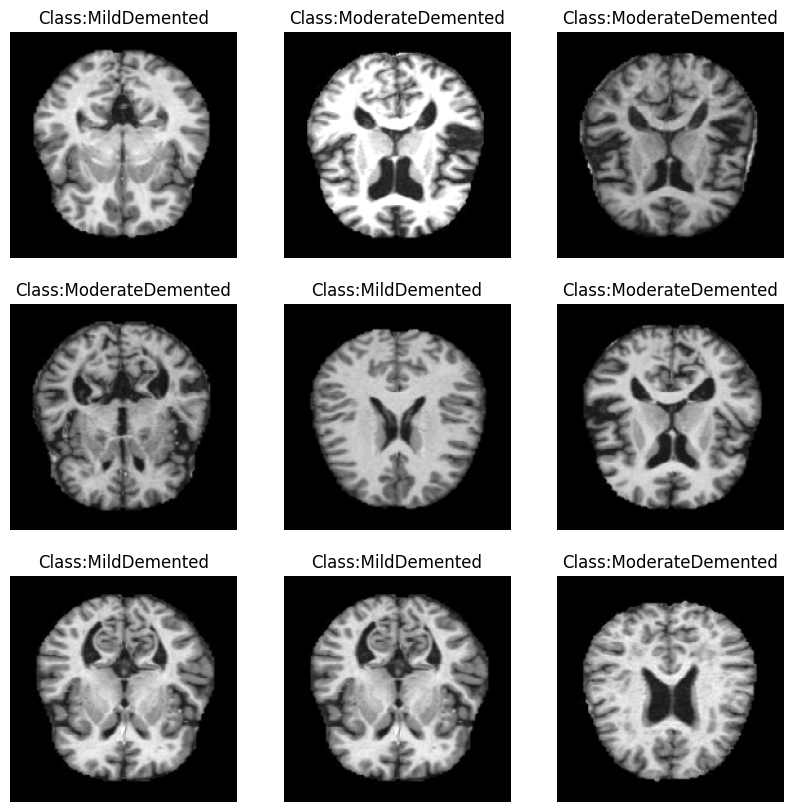

In [42]:
def show_images(generator,y_pred=None):
  
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a lot of images
    x, y = next(generator)

    
    # show a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0,50)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_dataset)

<BarContainer object of 4 artists>

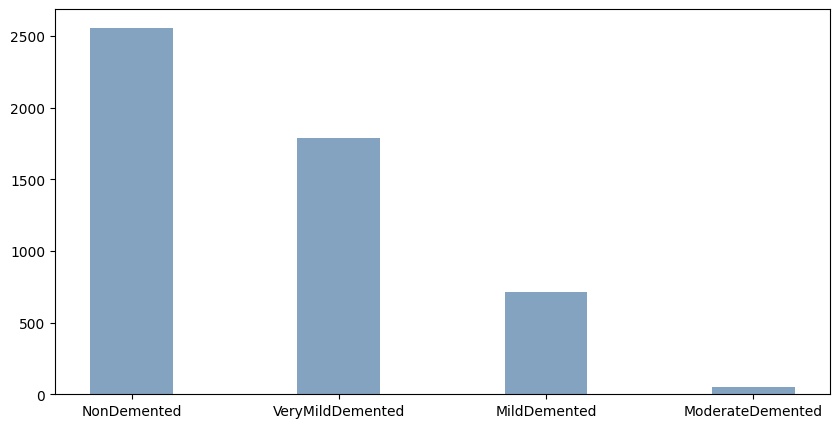

In [43]:
data = {'NonDemented':      0, 
        'VeryMildDemented': 0, 
        'MildDemented':     0,
        'ModerateDemented': 0}

# visualizing dataset
for cls in os.listdir(work_dir):
    for img in os.listdir(work_dir + '/' + cls):
        data[cls] = data[cls] + 1
        
keys = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (10, 5))
 
plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)

## Feature Engineering and Oversampling

In [ ]:
train_data, train_labels = next(train_dataset)

In [45]:
print(train_data.shape, train_labels.shape)

(5119, 176, 176, 3) (5119, 4)


In [46]:
#resampling data

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(10240, 176, 176, 3) (10240, 4)


In [47]:
from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

# Training models

## CNN

In [48]:
model = keras.models.Sequential([
keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape = [176,176,3]),
keras.layers.MaxPooling2D(),
keras.layers.Conv2D(32, (2, 2), activation='relu'),
keras.layers.MaxPooling2D(),

keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(64, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),

keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(128, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.SeparableConv2D(256, 3, activation='relu', padding='same'),
keras.layers.BatchNormalization(),
keras.layers.MaxPool2D(),
keras.layers.Dropout(0.2),

keras.layers.Flatten(),

keras.layers.Dense(512, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.7),

keras.layers.Dense(128, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.5),

keras.layers.Dense(64, activation='relu'),
keras.layers.BatchNormalization(),
keras.layers.Dropout(0.3),

keras.layers.Dense(4, activation ='softmax')])

c:\Users\KIIT\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [49]:
model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc'),
                 keras.metrics.AUC(name='auc')]
    )

In [50]:
history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), epochs=50)

Epoch 1/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 51s 213ms/step - acc: 0.2811 - auc: 0.5343 - loss: 1.8433 - val_acc: 0.2447 - val_auc: 0.5027 - val_loss: 1.3871
Epoch 2/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 43s 208ms/step - acc: 0.4146 - auc: 0.7018 - loss: 1.2770 - val_acc: 0.2447 - val_auc: 0.5288 - val_loss: 1.8076
Epoch 3/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - acc: 0.5976 - auc: 0.8533 - loss: 0.8967 - val_acc: 0.3405 - val_auc: 0.5816 - val_loss: 1.9048
Epoch 4/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 44s 213ms/step - acc: 0.6489 - auc: 0.8945 - loss: 0.7551 - val_acc: 0.5040 - val_auc: 0.7924 - val_loss: 1.0685
Epoch 5/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 44s 216ms/step - acc: 0.6922 - auc: 0.9170 - loss: 0.6728 - val_acc: 0.2739 - val_auc: 0.5997 - val_loss: 2.8384
Epoch 6/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 45s 218ms/step - acc: 0.6999 - auc: 0.9209 - loss: 0.6515 - val_acc: 0.4985 - val_auc: 0.8203 - val_loss: 1.4371
Epoch 7/50
205/205 ━━━━━━━━━━━━━━━━━━━━ 45s 217ms/step - acc: 0.7211 - auc: 0.9316

In [51]:
loss, accuracy,auc = model.evaluate(test_data, test_labels)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

64/64 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - acc: 0.8812 - auc: 0.9762 - loss: 0.4075
Loss:  0.47143709659576416
Accuracy:  0.86279296875


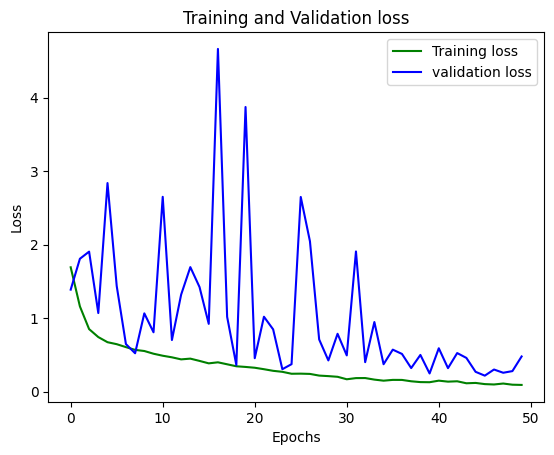

In [52]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(0,50)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

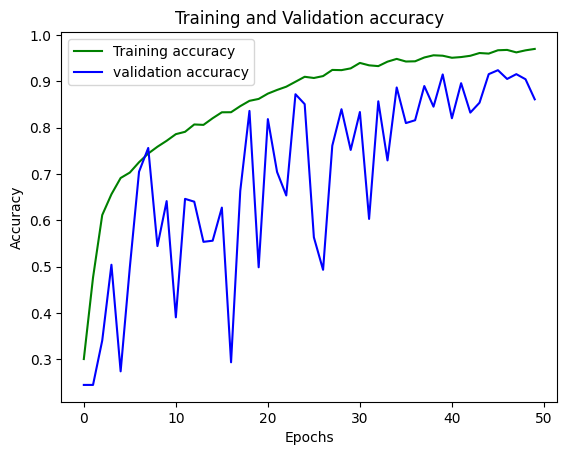

In [53]:
acc_train = history.history['acc']
acc_val = history.history['val_acc']
epochs = range(0,50)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [54]:
model.save('my_model.h5')

In [55]:
from pathlib import Path
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#Image path 
path = Path('dataset/ModerateDemented/moderateDem0.jpg')
img = image.load_img(path, target_size=(176,176))
image_array = img_to_array(img) / 255.0
image_array = np.expand_dims(image_array, axis=0)

img_array = image_array.reshape((1, 176, 176, 3))


predictions = model.predict(image_array)

#print(predictions)
predicted_label = train_labels[np.argmax(predictions)]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
